In [1]:
import functools
import os

from absl import app, flags
from einops import rearrange
from flax import jax_utils
from flax.training import orbax_utils, train_state
import jax
import jax.numpy as jnp
from ml_collections import config_flags, ConfigDict
import numpy as np
from orbax.checkpoint import CheckpointManager, CheckpointManagerOptions
from orbax.checkpoint import PyTreeCheckpointer
import optax
from tqdm import tqdm
import wandb

from ddprism import diffusion
from ddprism import linalg
from ddprism import training_utils
from ddprism import utils
from ddprism.metrics import metrics, image_metrics

import datasets
import config_base_grass, config_base_mnist

import matplotlib.pyplot as plt

2025-07-27 16:43:27.703052: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753649007.811866 1447744 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753649007.828653 1447744 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753649008.025467 1447744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753649008.025488 1447744 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753649008.025490 1447744 computation_placer.cc:177] computation placer alr

In [27]:
def create_posterior_train_state(
    rng, config, config_grass, image_shape, mu_x=None, cov_x=None,
    gaussian=False
):
    "Create joint posterior denoiser."
    learning_rate_fn = training_utils.get_learning_rate_schedule(
        config, config.lr_init_val, config.epochs
    )

    denoiser_models = [
        training_utils.create_denoiser_unet(config_grass, image_shape)
    ]
    if gaussian:
        denoiser_models.append(
            training_utils.create_denoiser_gaussian(config)
        )
    else:
        denoiser_models.append(
            training_utils.create_denoiser_unet(config, image_shape)
        )

    # Joint Denoiser
    feat_dim = image_shape[0] * image_shape[1] * image_shape[2]
    posterior_denoiser = diffusion.PosteriorDenoiserJoint(
        denoiser_models=denoiser_models, y_features=feat_dim * 2,
        rtol=config.post_rtol, maxiter=config.post_maxiter,
        use_dplr=config.post_use_dplr,
        safe_divide=config.get('post_safe_divide', 1e-32),
        regularization=config.get('post_regularization', 0.0),
        error_threshold=config.get('post_error_threshold', None)
    )

    # Initialize posterior denoiser.
    params = posterior_denoiser.init(
        rng, jnp.ones((1, feat_dim * 2)), jnp.ones((1,))
    )
    if mu_x is not None:
        params['params']['denoiser_models_1']['mu_x'] = mu_x
    if cov_x is not None:
        params['params']['denoiser_models_1']['cov_x'] = cov_x

    # Use the new configurable optimizer
    optimizer = training_utils.get_optimizer(config)(learning_rate_fn)
    grad_clip_norm = config.get('grad_clip_norm', 1.0)
    tx = optax.chain(optax.clip_by_global_norm(grad_clip_norm), optimizer)

    return train_state.TrainState.create(
        apply_fn=posterior_denoiser.apply, params=params['params'], tx=tx
    )


In [45]:
config = config_base_grass.get_config()

imagenet_path = '/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/dataset/grass_jpeg/'
rng = jax.random.PRNGKey(config.rng_key)

print(f'Found devices {jax.local_devices()}')

# Load the relevant information for the grass model.
grass_workdir = '/mnt/home/aakhmetzhanova/ceph/ddprism/corrupted_mnist/train_grass_post_err_thr_5/'
checkpointer = PyTreeCheckpointer()
checkpoint_options = CheckpointManagerOptions(
        enable_async_checkpointing=False
    )
checkpoint_manager = CheckpointManager(
        os.path.join(grass_workdir, 'checkpoints'), checkpointer,
        options=checkpoint_options, 
    )

grass_lap = -1 #FLAGS.grass_lap
if grass_lap == -1:
    grass_lap = checkpoint_manager.latest_step()
print(
        f'Loading grass model from {grass_workdir} at checkpoint {grass_lap}.'
    )
restore = checkpoint_manager.restore(grass_lap)
grass_params = restore['ema_params']
grass_state = restore['state']
config_grass = ConfigDict(restore['config'])
checkpoint_manager.close()


Found devices [CudaDevice(id=0)]
Loading grass model from /mnt/home/aakhmetzhanova/ceph/ddprism/corrupted_mnist/train_grass_post_err_thr_5/ at checkpoint 2.


In [53]:
restore['x_post'].shape

(32768, 784)

## Draw samples from the prior



In [46]:
# Create a sampling function for the prior.
def sample_prior(
        rng, state_local, params_local, image_shape, sample_batch_size,
        sampling_kwargs
    ):
    return utils.sample(
            rng, state_local, {'params': params_local},
            sample_shape=(sample_batch_size,),
            feature_shape=image_shape[0] * image_shape[1] * image_shape[2],
            **sampling_kwargs
        )
# Only sample as much as we need for the metrics.
n_prior_samples = 16
batch_size = 16
image_shape = (28, 28, 1)


In [48]:
rng = jax.random.key(config_grass.rng_key)
rng_state, rng = jax.random.split(rng)

learning_rate_fn = training_utils.get_learning_rate_schedule(
        config_grass, config_grass.lr_init_val, config_grass.epochs
    )
state_unet = training_utils.create_train_state_unet(
        rng_state, config_grass, learning_rate_fn, image_shape
    )


In [49]:
prior_samples = sample_prior(
    rng, state_unet, grass_params, image_shape, n_prior_samples, sampling_kwargs=config_grass.sampling_kwargs
    )
prior_samples = prior_samples.reshape(n_prior_samples, image_shape[0], image_shape[1], image_shape[2])
prior_samples.shape

(16, 28, 28, 1)

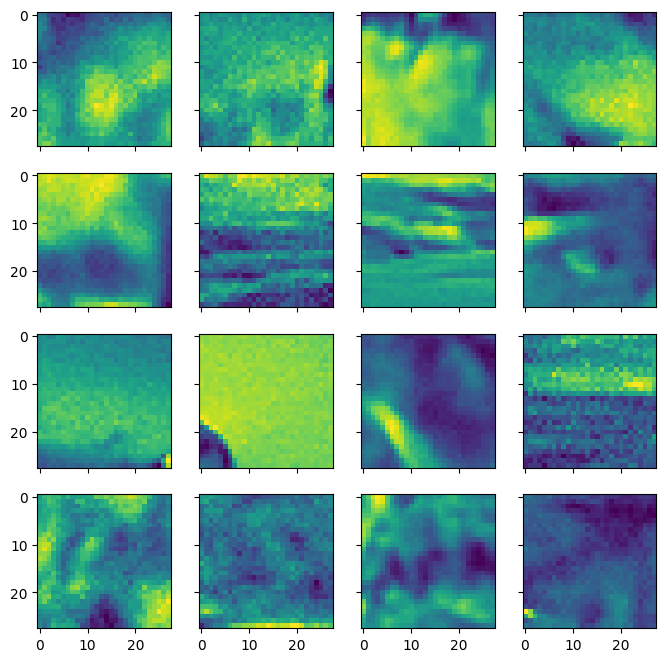

In [50]:
fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(8, 8))

for row in range(4):
    for column in range(4):
        axs[row, column].imshow(prior_samples[row*4 + column])
